In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports Libraries and Tools

In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

# Load Datasets

In [3]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI/Training/'
test_dir = '/content/drive/MyDrive/MRI/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

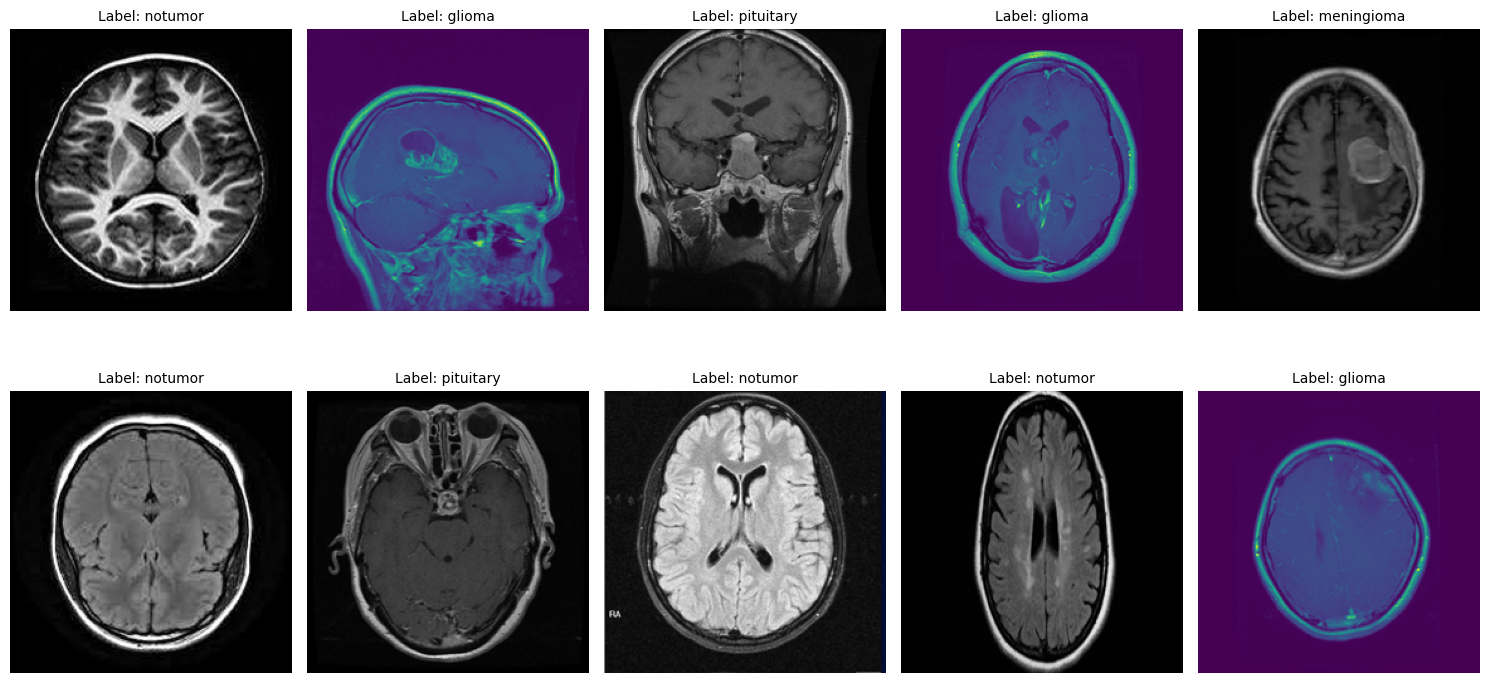

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [5]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL:

## WE ARE USING VGG16 FOR TRANSFER LEARNING.

 The model is built on top of VGG16, which is a pre-trained convolutional neural network (CNN) for image classification.

* First, the VGG16 model is loaded with input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet'. The input shape is set to match the size of the images in the dataset, which is 128x128 pixels. The include_top parameter is set to False, which means that the final fully-connected layers of VGG16 that perform the classification will not be included. The weights parameter is set to 'imagenet' which means that the model will be pre-trained with a dataset of 1.4 million images called imagenet

* Next, the for layer in base_model.layers: loop is used to set all layers of the base_model (VGG16) to non-trainable, so that the weights of these layers will not be updated during training.

* Then, the last three layers of the VGG16 model are set to trainable by using base_model.layers[-2].trainable = True,base_model.layers[-3].trainable = True and base_model.layers[-4].trainable = True

* After that, a Sequential model is created and the VGG16 model is added to it with model.add(base_model).

* Next, a Flatten layer is added to the model with model.add(Flatten()) which reshapes the output of the VGG16 model from a 3D tensor to a 1D tensor, so that it can be processed by the next layers of the model.

* Then, a Dropout layer is added with model.add(Dropout(0.3)) which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

* After that, a dense layer is added with 128 neurons and relu activation function is added with model.add(Dense(128, activation='relu')).

* Next, another Dropout layer is added with model.add(Dropout(0.2))

* Finally, the output dense layer is added with number of neurons equal to the number of unique labels and 'softmax' activation function is added with model.add(Dense(len(unique_labels), activation='softmax')). The 'softmax' activation function is used to give a probability distribution over the possible classes.




In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 20  # Increased from 5 to 20

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs,
                    steps_per_epoch=steps,
                    callbacks=[reduce_lr])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1624s 6s/step - loss: 0.6403 - sparse_categorical_accuracy: 0.7409 - learning_rate: 1.0000e-04
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - loss: 0.2680 - sparse_categorical_accuracy: 0.8999 - learning_rate: 1.0000e-04
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - loss: 0.1808 - sparse_categorical_accuracy: 0.9341 - learning_rate: 1.0000e-04
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9498 - learning_rate: 1.0000e-04
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9651 - learning_rate: 1.0000e-04
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9761 - learning_rate: 1.0000e-04
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - loss: 0.0523 - sparse_categorical_accuracy: 0.9819 - learning_rate: 1.0000e-0

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# -----------------------------
# Config (USER REQUIREMENTS)
# -----------------------------
IMG_SIZE = (128, 128)
BATCH_SIZE = 20
EPOCHS = 30
LEARNING_RATE = 1e-4

DATASET_ROOT_DIR = "/content/drive/MyDrive/MRI"

BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "model")
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "vgg16_model.h5")

# -----------------------------
# Data Generators
# -----------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(DATASET_ROOT_DIR, "Training"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    os.path.join(DATASET_ROOT_DIR, "Testing"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ✅ SAFE way to get number of classes
NUM_CLASSES = train_data.num_classes
print("Detected classes:", train_data.class_indices)

# -----------------------------
# Base Model (VGG16)
# -----------------------------
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# -----------------------------
# Custom Classifier
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# -----------------------------
# Compile
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -----------------------------
# Callbacks
# -----------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

# -----------------------------
# Training
# -----------------------------
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

# -----------------------------
# FINAL SAVE (FLASK SAFE)
# -----------------------------
model.save(MODEL_PATH, include_optimizer=False)

print("\n✅ Training completed successfully")
print(f"✅ Model saved at: {MODEL_PATH}")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Detected classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30


# Train and Val Plots

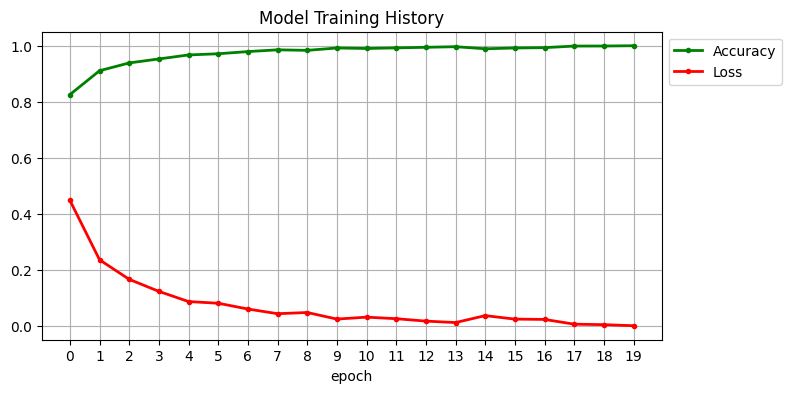

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.99      0.99      0.99       300
           2       0.96      0.97      0.97       306
           3       0.98      0.96      0.97       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



# Model Confusion Plot

Confusion Matrix:
[[405   0   0   0]
 [  1 297   1   1]
 [  0   3 298   5]
 [  0   1  12 287]]


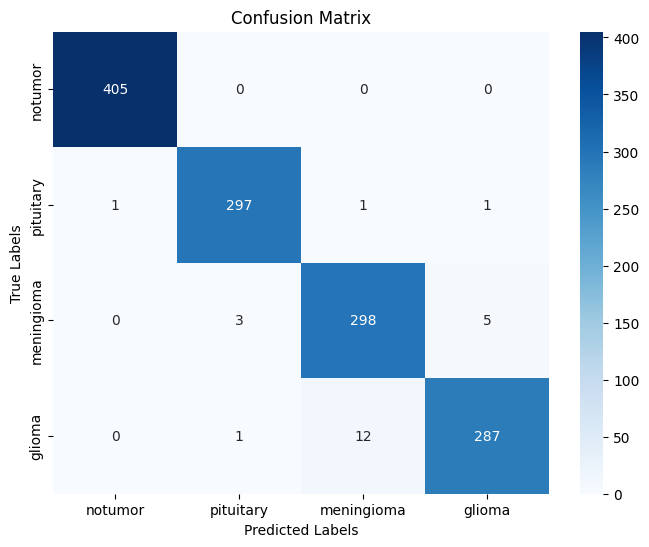

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


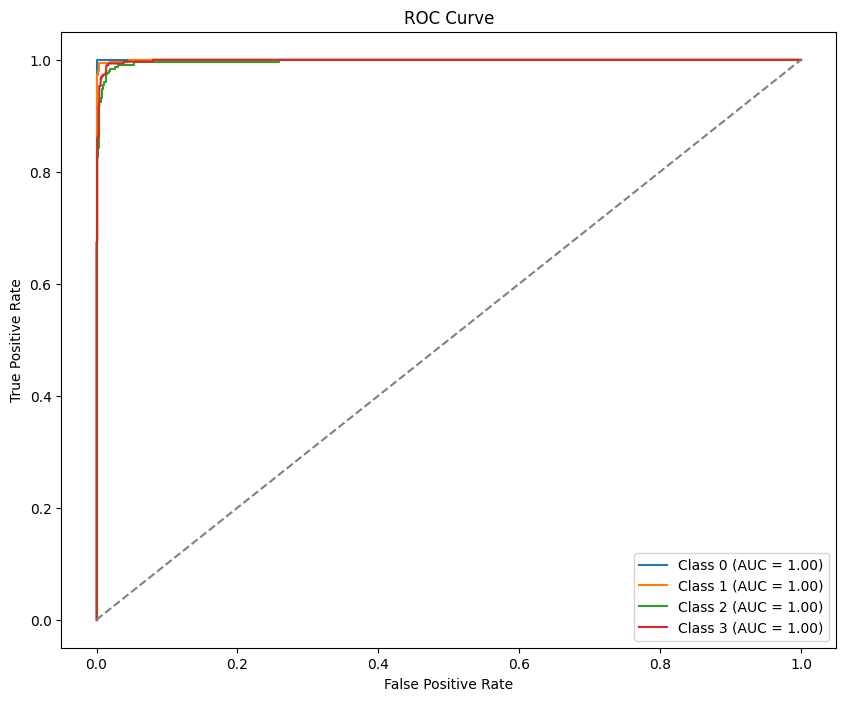

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

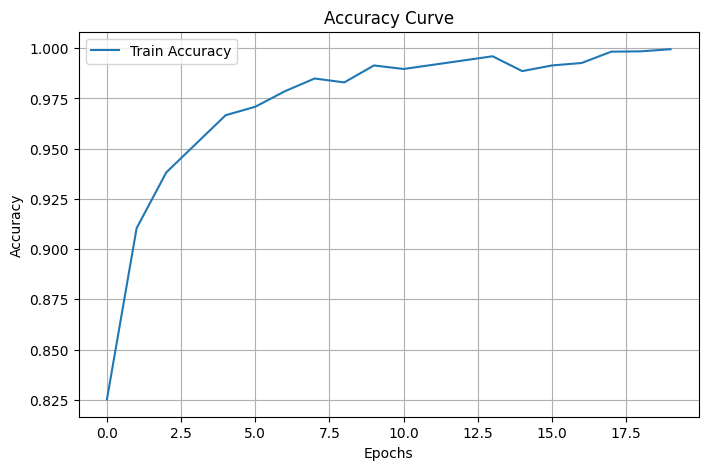

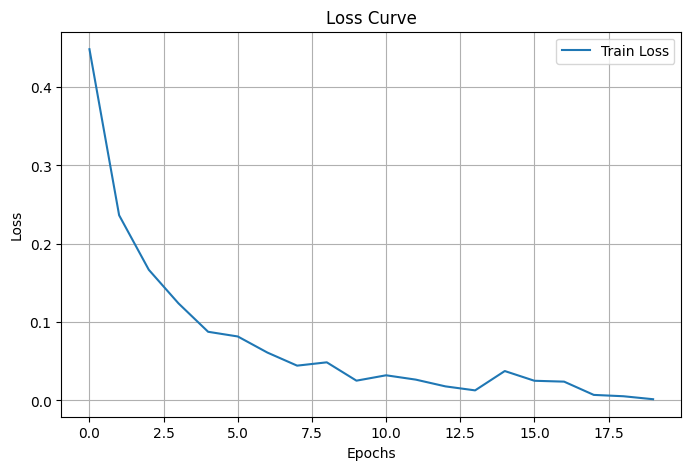

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = np.argmax(test_predictions, axis=1)

precision = precision_score(test_labels_encoded, y_pred, average='weighted')
recall = recall_score(test_labels_encoded, y_pred, average='weighted')
f1 = f1_score(test_labels_encoded, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.981755461934606
Recall: 0.9816933638443935
F1-score: 0.9816776412192907


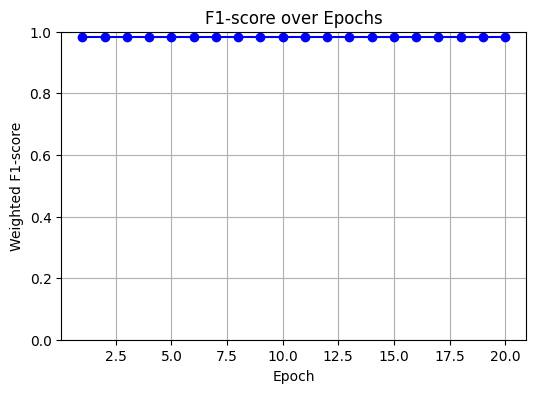

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# The variable `test_predictions_per_epoch` is not defined in the current scope.
# To make the plot runnable, we'll simulate it using the final test_predictions
# for all epochs. Note that this will show a constant F1-score across epochs
# as per-epoch test predictions were not explicitly stored during training.

# 'epochs' is available from the training cell (9fa272d5)
# 'test_predictions' and 'test_labels_encoded' are available from earlier cells (a57457b7)

# Create a list where each element is the final test_predictions, repeated for each epoch.
# This makes the code runnable, but doesn't show actual F1-score evolution per epoch.
# If you need per-epoch F1 scores, the training loop would need to be modified
# to evaluate the model on the test set after each epoch and store the predictions.

test_predictions_per_epoch = [test_predictions] * epochs
N_epochs = len(test_predictions_per_epoch)

f1_scores = []

for epoch_preds in test_predictions_per_epoch:
    y_pred = np.argmax(epoch_preds, axis=1)  # convert probabilities to class labels
    f1 = f1_score(test_labels_encoded, y_pred, average='weighted')
    f1_scores.append(f1)

# Plot F1-score curve over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, N_epochs + 1), f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Weighted F1-score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

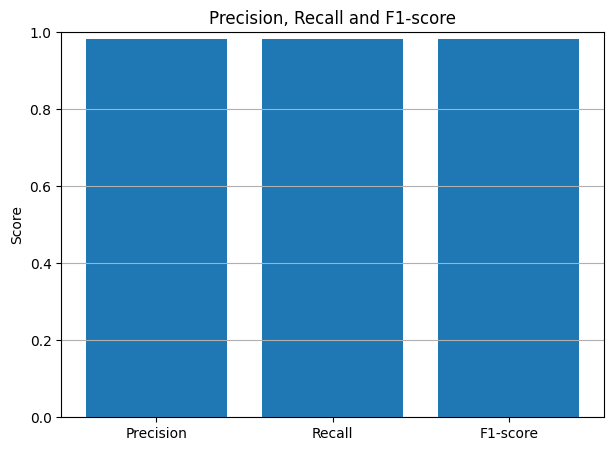

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert probabilities to class labels
y_pred = np.argmax(test_predictions, axis=1)

# Compute metrics
precision = precision_score(test_labels_encoded, y_pred, average='weighted')
recall = recall_score(test_labels_encoded, y_pred, average='weighted')
f1 = f1_score(test_labels_encoded, y_pred, average='weighted')

# Plot
metrics = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1]

plt.figure(figsize=(7, 5))
plt.bar(metrics, values)
plt.title('Precision, Recall and F1-score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


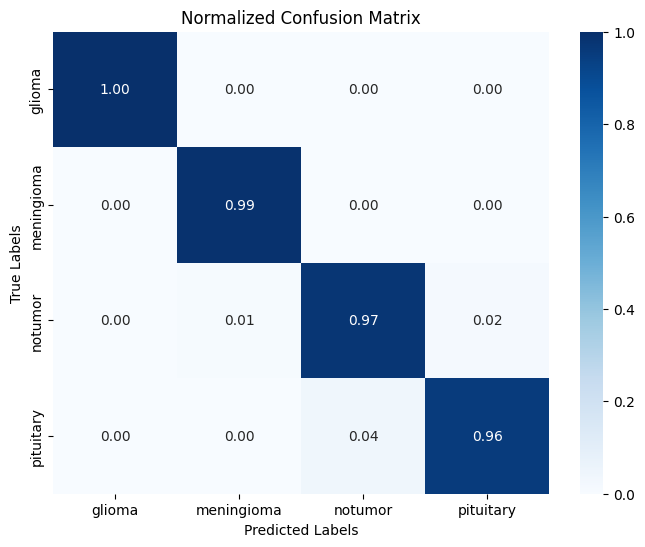

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Get class names in correct order
class_names = sorted(os.listdir(train_dir))

# Create confusion matrix
conf_matrix = confusion_matrix(
    test_labels_encoded,
    np.argmax(test_predictions, axis=1)
)

# Normalize confusion matrix (row-wise)
conf_matrix_norm = conf_matrix.astype(float) / conf_matrix.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Save & Load Model

In [ ]:
# Save model architecture
with open("vgg16_model.json", "w") as f:
    f.write(model.to_json())

In [ ]:
from google.colab import files

files.download("vgg16_model.json")
# The file 'vgg16_weights.weights.h5' was not explicitly saved in the notebook.
# If you intended to save only the VGG16 weights, you would need to add a command like:
# model.get_layer('vgg16').save_weights('vgg16_weights.weights.h5')
# Since the entire model was saved as 'model.h5' and already downloaded, this line is not needed here.
# files.download("vgg16_weights.weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the entire model
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model.h5')

In [ ]:
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>